In [15]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import dataset_L2 as dataset  # 假设你的数据加载脚本名为dataset_L2.py
import matplotlib

In [16]:
BACKBONE = 'vgg16'
MODEL_PATH = f'my_model/{BACKBONE}/L3_{BACKBONE}_best_model.pkl'
BATCH_SIZE = 32
NUM_NEIGHBORS = 5
VISUALIZE = False

In [17]:
def load_model(backbone):
    if backbone == 'alexnet':
        model = models.alexnet(pretrained=False)
        model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    elif backbone == 'resnet18':
        model = models.resnet18(pretrained=False)
        model = nn.Sequential(*list(model.children())[:-1])
    elif backbone == 'vgg16':
        model = models.vgg16(pretrained=False)
        model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    else:
        raise ValueError("Unsupported backbone")

    model.load_state_dict(torch.load(MODEL_PATH), strict=False)
    return model

In [18]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.cuda()
            outputs = model(inputs).squeeze()
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)


In [19]:
train_loader, _, _ = dataset.get_dataset('data/labels.csv', '', 224, BATCH_SIZE, is_train=True,
                                             is_sampling='no_sampler')

model = load_model(BACKBONE).cuda()

features, labels = extract_features(model, train_loader)

----Training Mode----
Dataset: (800, 224, 224, 3), labels=[('0', 619), ('1', 181)]
----Testing Mode----
Test set: (800, 224, 224, 3), labels=[('0', 619), ('1', 181)]


D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=NUM_NEIGHBORS)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy: {accuracy:.4f}")

KNN Accuracy: 0.8308


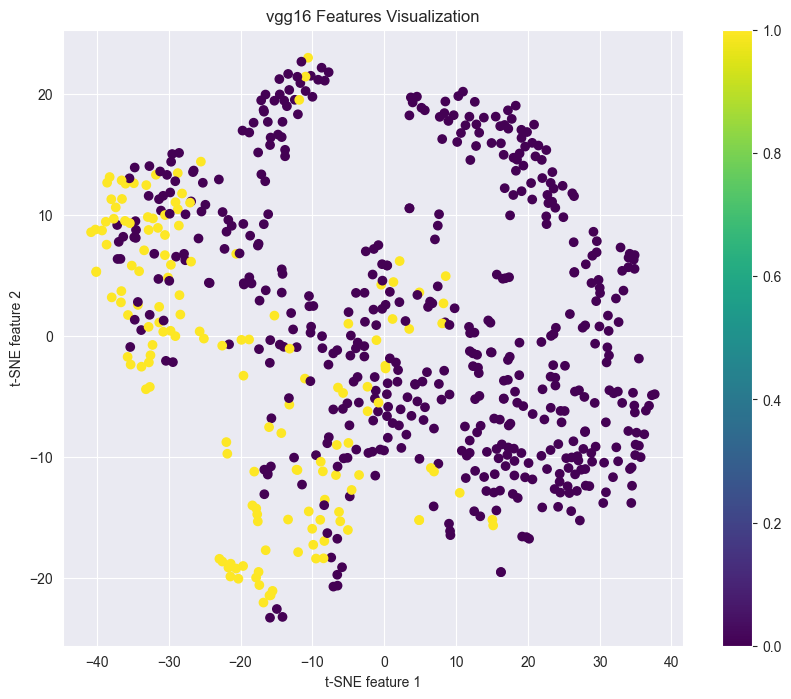

In [21]:
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'{BACKBONE} Features Visualization')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.savefig(f'{BACKBONE}_tsne_visualization.png')
plt.show()

In [22]:
from mpl_toolkits.mplot3d import Axes3D 
tsne = TSNE(n_components=3, random_state=42)
features_3d = tsne.fit_transform(features)

import plotly.graph_objects as go

x = features_3d[:, 0].flatten()
y = features_3d[:, 1].flatten()
z = features_3d[:, 2].flatten()
colors = labels.flatten()

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(title=f'{BACKBONE} Features 3D Visualization')
fig.show()

In [12]:
print(matplotlib.__version__)

3.9.0
